
### Marcenko-Pastur Law / Quarter Circle Law

http://math.mit.edu/~edelman/publications/random_matrix_theory_innovative.pdf


This time, I ensure W has norm 1


In [1]:
import numpy as np
import tensorflow as tf
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
print(sklearn.__version__)

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


0.19.1


In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K


model = Sequential()
model.add(Conv2D(96, (5, 5), input_shape=(28, 28, 3), kernel_initializer=
                 'glorot_normal', bias_initializer=Constant(0.1), padding=
                 'same', activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (5, 5), kernel_initializer='glorot_normal',
                 bias_initializer=Constant(0.1), padding='same',
                 activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(384, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(192, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='softmax'))



sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())



Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
model.load_weights('weights/cifar10_alexnet.h5')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

In [4]:
modelfiles = ["cifar10_alexnet.h5", "alexnet.b2.final.h5", "cifar10_alexnet_wd.h5","cifar10_alexnet_rand_labels.h5", "alexnet.b512.final.h5" ,"alexnet.b16.rand100.final.h5", "alexnet.b2.rand100.final.h5"]
colors = ["green", "blue", "red", "orange", "cyan", "blue", "magenta"]

In [5]:
model.load_weights("weights/cifar10_alexnet.h5")
print(len(model.layers))
for il in [7,8,9]:
    print(il)
    W = model.layers[il].get_weights()[0]
    print(np.linalg.norm(W), np.linalg.matrix_rank(W))
        

10
7
24.3223 384
8
14.8385 192
9
5.89476 10


cifar10_alexnet.h5


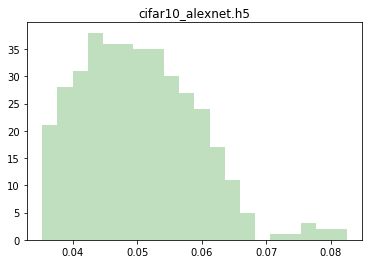

alexnet.b2.final.h5


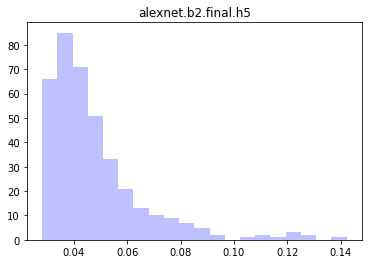

cifar10_alexnet_wd.h5


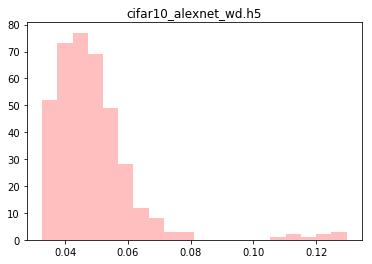

cifar10_alexnet_rand_labels.h5


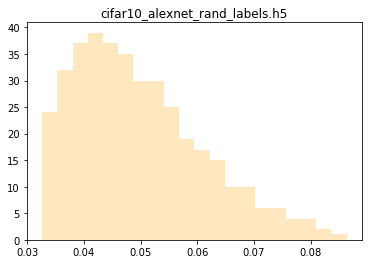

alexnet.b512.final.h5


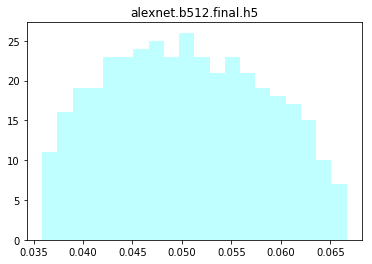

alexnet.b16.rand100.final.h5


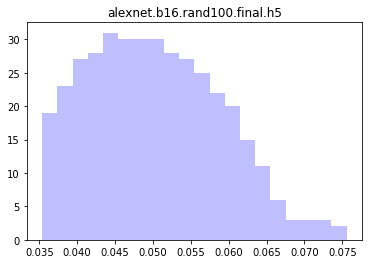

alexnet.b2.rand100.final.h5


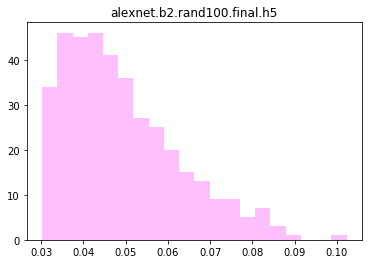

In [6]:
for modelfile, color in zip(modelfiles, colors):
    print(modelfile)
    model.load_weights("weights/{}".format(modelfile))
    W = model.layers[7].get_weights()[0]
    n = 384
    W = W / np.linalg.norm(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    plt.hist(sv, bins=20, alpha=0.25, color=color);
    plt.title(modelfile)
    plt.show()

In [115]:
all_singular_values = []
all_0_vectors = []

all_bleeding_vectors = []
all_wigner_vectors = []

with tqdm(total=75) as pbar:
    for idx in range(1,76):
        modelfile = "weights/alexnet.b16.id{}.final.h5".format(idx)
        model.load_weights(modelfile)
        W = model.layers[7].get_weights()[0]
        n = 384
        W = W / np.linalg.norm(W)
        svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
        svd.fit(W) 
        sv = svd.singular_values_
        all_singular_values.extend(sv)
        all_0_vectors.append(svd.components_[0])
        
        for  val, vec in zip(sv, svd.components_):
            if (val) > 0.07:
                all_bleeding_vectors.append(vec)
            else:
                all_wigner_vectors.append(vec)
            

        pbar.update(1)


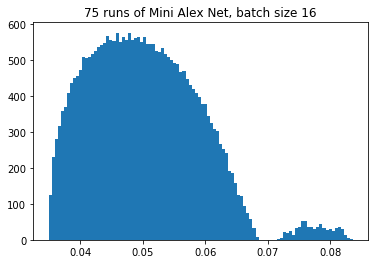

In [18]:
plt.hist(all_singular_values, bins=100);
plt.title(modelfile)
plt.title('75 runs of Mini Alex Net, batch size 16')
plt.show()


In [135]:
rand_singular_values = []
rand_0_vectors = []

with tqdm(total=49) as pbar:
    for idx in range(1,50):
        modelfile = "weights/alexnet.b16.rand100.id{}.final.h5".format(idx)
        model.load_weights(modelfile)
        W = model.layers[7].get_weights()[0]
        n = 384
        W = W / np.linalg.norm(W)
        svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
        svd.fit(W) 
        sv = svd.singular_values_
        rand_singular_values.extend(sv)
        rand_0_vectors.append(svd.components_[0])
        pbar.update(1)

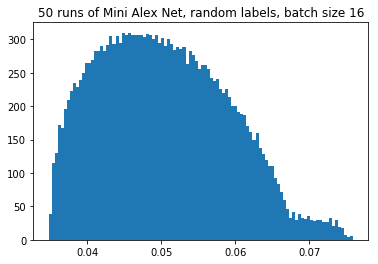

In [136]:
plt.hist(rand_singular_values, bins=100);
plt.title(modelfile)
plt.title("50 runs of Mini Alex Net, random labels, batch size 16")
plt.show()

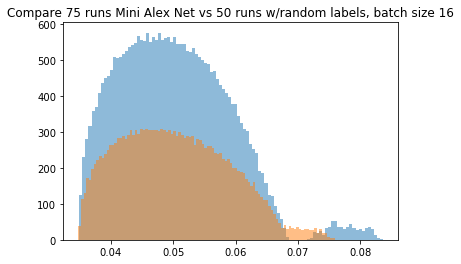

In [138]:
plt.hist(all_singular_values, bins=100, alpha=0.5);
plt.hist(rand_singular_values, bins=100, alpha=0.5);
plt.title('Compare 75 runs Mini Alex Net vs 50 runs w/random labels, batch size 16')
plt.show()

### Analysis of principle vector

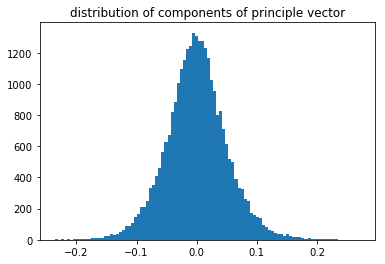

In [52]:
vec_comps = []
for vec in all_0_vectors:
    vec_comps.extend(vec)
plt.hist(vec_comps, bins=100);
plt.title('distribution of components of principle vector')

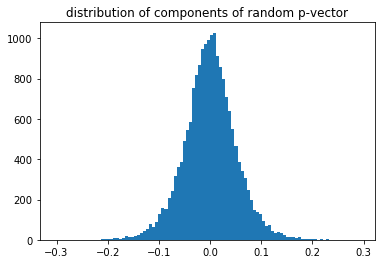

In [139]:
rand_comps = []
for vec in rand_0_vectors:
    rand_comps.extend(vec)
plt.hist(rand_comps, bins=100);
plt.title('distribution of components of random p-vector')

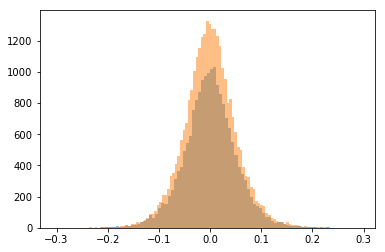

In [141]:
plt.hist(rand_comps, bins=100, alpha=0.5);
plt.hist(vec_comps, bins=100, alpha=0.5);


### Norms

In [142]:
all_norm_ratios = []
rand_norm_ratios = []

for vec in all_0_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    all_norm_ratios.append(nr)
    
for vec in rand_0_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    rand_norm_ratios.append(nr)
    

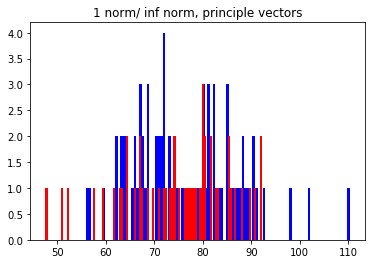

In [144]:
plt.hist(all_norm_ratios, color='blue', bins=100);
plt.hist(rand_norm_ratios, color='red', bins=100);
plt.title('1 norm/ inf norm, principle vectors')

https://arxiv.org/pdf/1401.5093.pdf

### Compare Wigner circle to bleeding out (first 9)  eigenvectors

In [77]:
all_singular_values[0:8], all_singular_values[9],

([0.081078872,
  0.080688864,
  0.079592377,
  0.077764332,
  0.07740245,
  0.076472238,
  0.076432988,
  0.075263366],
 0.067543648)

In [147]:
len(all_0_vectors), len()

75

In [145]:
#wigner_norm_ratios = []
bleeding_norm_ratios = []

for vec in all_0_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    bleeding_norm_ratios.append(nr)
    


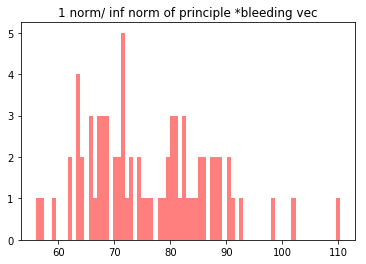

In [146]:
plt.hist(bleeding_norm_ratios, color='red', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of principle *bleeding vec')

### Plot singular value vs norm ratio

In [148]:
bleeding_norm_ratios = []
wigner_norm_ratios = []
for vec in all_bleeding_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    bleeding_norm_ratios.append(nr)
    
for vec in all_wigner_vectors:
    nr = np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)
    wigner_norm_ratios.append(nr)

In [153]:
len(bleeding_norm_ratios), len(wigner_norm_ratios)

(675, 28050)

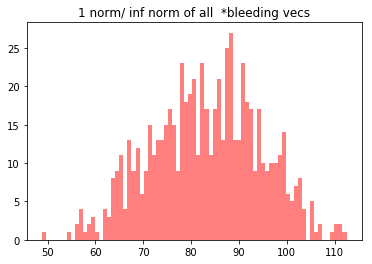

In [154]:
plt.hist(bleeding_norm_ratios, color='red', bins=75, alpha=0.5);

plt.title('1 norm/ inf norm of all  *bleeding vecs')

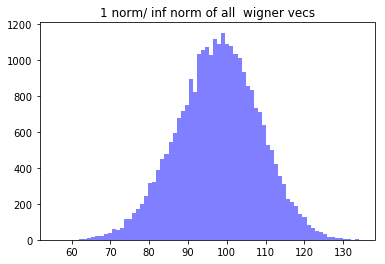

In [155]:
plt.hist(wigner_norm_ratios, color='blue', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of all  wigner vecs')

In [151]:
np.mean(bleeding_norm_ratios), np.mean(wigner_norm_ratios)

(83.180283, 97.775116)

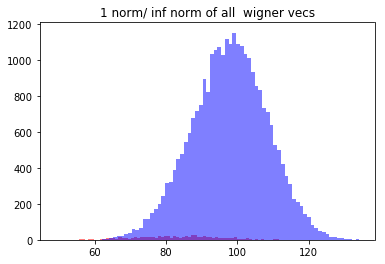

In [156]:
plt.hist(bleeding_norm_ratios, color='red', bins=75, alpha=0.5);
plt.hist(wigner_norm_ratios, color='blue', bins=75, alpha=0.5);
plt.title('1 norm/ inf norm of all  wigner vecs')